# anomaly_detection.ipynb

#### A code to use the anomaly detection strategy to train the thresholds for the variability parameters eta and V

#### Import all the dependencies and generic setup

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
import os
import glob
import numpy as np
import pandas as pd
from scipy import optimize
import tkp.db
import logging
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
import sys
sys.path.append('../')
from dblogin import * # This file contains all the variables required to connect to the database
from database_tools import dbtools
from tools import tools
from plotting import plot_varib_params as pltvp
from machine_learning import train_anomaly_detect
from machine_learning import generic_tools
from matplotlib.colors import LinearSegmentedColormap
import random
from matplotlib.colors import LogNorm
import seaborn as sns

../machine_learning/train_anomaly_detect.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/antoniar/TraP_ML_tools_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/antoniar/TraP_ML_tools_env/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/antoniar/TraP_ML_tools_env/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self

#### The input data and thresholds

In [30]:
tests = False
plots = False
precis_thresh = 0.95
recall_thresh = 0.95
path='ml_csv_files/'
stableData = path+'stable_sources.csv'
simulatedData = path+'sim_*_trans_data.csv'

In [31]:
def newCmap(colour):
    n,r,g,b = colour
    cdict = {'red':((0,1,1),(1,r,r)),
            'green':((0,1,1),(1,g,g)),
            'blue':((0,1,1),(1,b,b))}
    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

#### Load the data and give appropriate labels

In [32]:
all_data = generic_tools.load_data(stableData,simulatedData)

#### Load the simulations and only keep those with a full lightcurve and with variability parameters > 0

In [33]:
all_data=all_data.loc[(all_data['ttype'] == 2) & (all_data['V']>0.) & (all_data['eta']>0.)]

#### put the training data into the format required for the training 

In [34]:
train_data = all_data.apply(lambda row:[np.log10(row['eta']),np.log10(row['V']),row['variable'],row['label']],axis=1)
train_data = train_data.as_matrix()

/home/antoniar/TraP_ML_tools_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### Obtain the training data if it doesn't already exist on disk (SLOW!)

In [35]:
if not os.path.exists('ml_csv_files/sigma_data.txt'):
    filename = open("ml_csv_files/sigma_data.txt", "w")
    filename.write('')
    filename.close()
    train_anomaly_detect.multiple_trials(train_data,path+"sigma_data.txt")
data2=np.genfromtxt(path+'sigma_data.txt', delimiter=' ')

#### Using the training data, find the sigma threshold combination that best fits input thresholds

In [36]:
best_sigma1, best_sigma2 = train_anomaly_detect.find_best_sigmas(precis_thresh,recall_thresh,data2,tests,train_data,plots,path)
print 'sigma_(eta_nu)='+str(best_sigma1)+', sigma_(V_nu)='+str(best_sigma2) 

Best sigmas found:2.92542542543, 1.4049049049
sigma_(eta_nu)=2.92542542543, sigma_(V_nu)=1.4049049049


In [49]:
#tryThresh=[0.75,0.8,0.85,0.9,0.95]
#results=[]
#for pthresh in tryThresh:
#    for rthresh in tryThresh:
#        tmp_all_data=all_data
#        best_sigma1, best_sigma2 = train_anomaly_detect.find_best_sigmas(pthresh,rthresh,data2,tests,train_data,plots,path)
#        sigcutx,paramx,range_x = generic_tools.get_sigcut([a[0] for a in train_data if a[2]==0.],best_sigma1)
#        sigcuty,paramy,range_y = generic_tools.get_sigcut([a[1] for a in train_data if a[2]==0.],best_sigma2)
#        threshx=10.**sigcutx
#        threshy=10.**sigcuty
#        tmp_all_data.loc[(((tmp_all_data['eta']<threshx) | (tmp_all_data['V']<threshy)) & (tmp_all_data['variable'] == 1)),'classified'] = 'FN'
#        tmp_all_data.loc[((tmp_all_data['eta']>=threshx) & (tmp_all_data['V']>=threshy) & (tmp_all_data['variable'] == 1)),'classified'] = 'TP'
#        tmp_all_data.loc[(((tmp_all_data['eta']<threshx) | (tmp_all_data['V']<threshy)) & (tmp_all_data['variable'] == 0)),'classified'] = 'TN'
#        tmp_all_data.loc[((tmp_all_data['eta']>=threshx) & (tmp_all_data['V']>=threshy) & (tmp_all_data['variable'] == 0)),'classified'] = 'FP'
#        precision, recall =  generic_tools.precision_and_recall(len(tmp_all_data.loc[(tmp_all_data['classified'] == 'TP')]),len(tmp_all_data.loc[(tmp_all_data['classified'] == 'FP')]),len(tmp_all_data.loc[(tmp_all_data['classified'] == 'FN')]))
#        results.append([pthresh, rthresh, precision, recall])
        


#### Find the eta and V thresholds for the data

In [37]:
sigcutx,paramx,range_x = generic_tools.get_sigcut([a[0] for a in train_data if a[2]==0.],best_sigma1)
sigcuty,paramy,range_y = generic_tools.get_sigcut([a[1] for a in train_data if a[2]==0.],best_sigma2)
print(r'Gaussian Fit $\eta$: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print(r'Gaussian Fit $V$: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')
print 'Eta_nu threshold='+str(10.**sigcutx)+', V_nu threshold='+str(10.**sigcuty)

threshx=10.**sigcutx
threshy=10.**sigcuty

Gaussian Fit $\eta$: 0.29(+0.86 -0.22)
Gaussian Fit $V$: 0.07(+0.09 -0.04)
Eta_nu threshold=15.8159296905, V_nu threshold=0.219329581402


#### Calculate the false positives (FP), true negatives (TN), true positives (TP) and false negatives (FN)

In [38]:
all_data.loc[(((all_data['eta']<threshx) | (all_data['V']<threshy)) & (all_data['variable'] == 1)),'classified'] = 'FN'
all_data.loc[((all_data['eta']>=threshx) & (all_data['V']>=threshy) & (all_data['variable'] == 1)),'classified'] = 'TP'
all_data.loc[(((all_data['eta']<threshx) | (all_data['V']<threshy)) & (all_data['variable'] == 0)),'classified'] = 'TN'
all_data.loc[((all_data['eta']>=threshx) & (all_data['V']>=threshy) & (all_data['variable'] == 0)),'classified'] = 'FP'

#### Find candidates
As we assumed all the real data were stable sources, the candidate variables are those classified as FP

In [39]:
all_data.loc[(all_data['classified'] == 'FP')]

,#Runcat,Dec,RA,V,detectionThreshold,detectionThreshold,dpts,eta,flux,fluxrat,freq,label,maxRmsSigma,minRmsSigma,ttype,variable,classified
1236,10101,54.773412,38.654170,0.233531,0.0,NaN,12,51.055195,1.125984,1.164609,185,stable,0.0,0.0,2,0,FP
2003,12582,51.915637,146.916801,0.270087,0.0,NaN,24,24.516529,0.996101,1.263989,185,stable,0.0,0.0,2,0,FP
2377,12677,51.536469,150.751067,0.309932,0.0,NaN,16,17.106837,0.815625,1.463289,185,stable,0.0,0.0,2,0,FP
2380,12670,49.754788,148.187863,0.486695,0.0,NaN,8,58.269373,0.963594,1.344145,185,stable,0.0,0.0,2,0,FP
3648,10503,54.579034,53.249017,0.224956,0.0,NaN,16,252.228360,4.234522,1.331150,185,stable,0.0,0.0,2,0,FP
4270,12590,53.218277,148.216414,0.231347,0.0,NaN,32,45.147196,2.166164,1.155166,185,stable,0.0,0.0,2,0,FP
4725,10115,54.674197,40.188706,0.314016,0.0,NaN,12,29.990486,0.697412,1.245295,185,stable,0.0,0.0,2,0,FP
5069,10099,54.245287,37.692081,0.365230,0.0,NaN,12,16.523494,0.569723,1.220851,185,stable,0.0,0.0,2,0,FP
5627,12682,50.200433,151.779243,0.496730,0.0,NaN,16,21.125165,0.609621,1.745002,185,stable,0.0,0.0,2,0,FP
5634,12689,53.286199,148.629707,0.629080,0.0,NaN,16,22.354197,0.818833,1.942806,185,stable,0.0,0.0,2,0,FP


#### Calculate the precision and recall

In [40]:
precision, recall =  generic_tools.precision_and_recall(len(all_data.loc[(all_data['classified'] == 'TP')]),len(all_data.loc[(all_data['classified'] == 'FP')]),len(all_data.loc[(all_data['classified'] == 'FN')]))

In [41]:
print "Precision: "+str(precision)+", Recall: "+str(recall)

Precision: 0.951768488746, Recall: 0.925


#### Create eta V plot showing training results

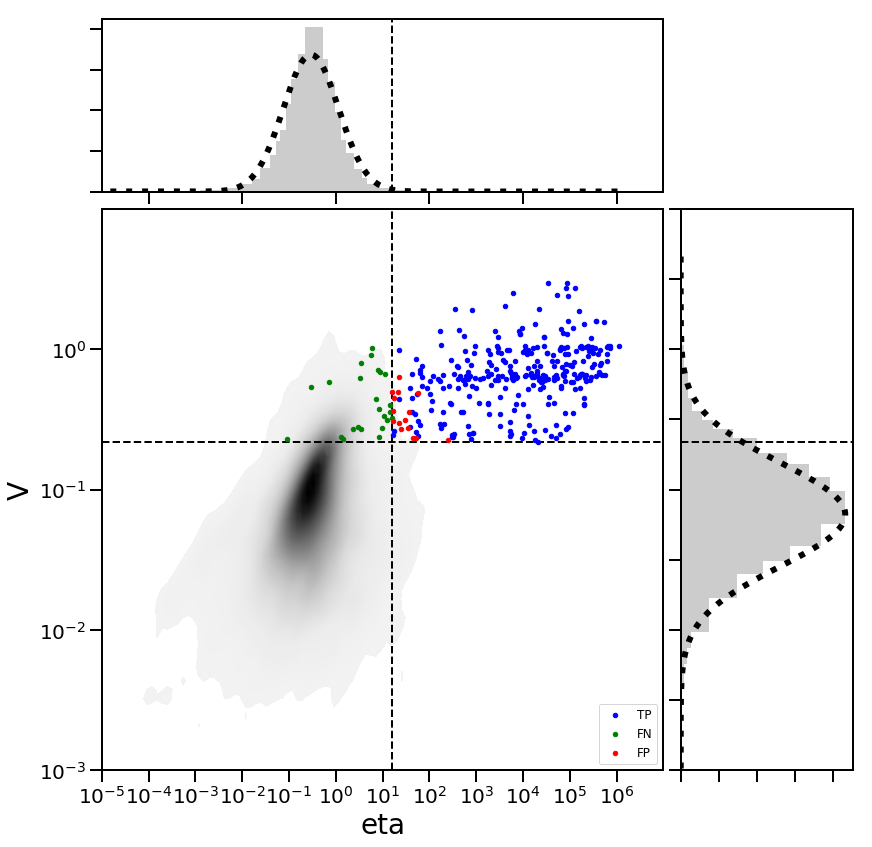

In [42]:
plotdata=all_data
frequencies=['TN','TP','FN','FP']
col=['k','b','g','r']

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(12,12))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])
                    


for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_var=np.log10(plotdataTMP['eta'])
    ydata_var=np.log10(plotdataTMP['V'])
    if frequencies[i] != 'TN':
        axScatter.scatter(xdata_var, ydata_var,color=col[i], s=20., zorder=5)
freq_labels=[f for f in frequencies if f!='TN']
axScatter.legend(freq_labels,loc=4, prop=fontP)

        
for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_var=np.log10(plotdataTMP['eta'])
    ydata_var=np.log10(plotdataTMP['V'])
    if frequencies[i] == 'TN':
        sns.kdeplot(np.log10(plotdataTMP.eta), np.log10(plotdataTMP.V), 
                    n_levels=1000, zorder=i, shade_lowest=False, shade=True, 
                    color='k', ax=axScatter, alpha=1)


x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=pltvp.make_bins(x), normed=1, histtype='stepfilled', color='k',alpha=0.2)
axHisty.hist(y, bins=pltvp.make_bins(y), normed=1, histtype='stepfilled', orientation='horizontal', color='k', alpha=0.2)

xmin=-5#int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=-3#int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

if sigcutx != 0 or sigcuty != 0:
    axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
    axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')

range_x,fitx = pltvp.gaussian_fit(x,paramx)
axHistx.plot(range_x,fitx, 'k:', linewidth=6)
range_y,fity = pltvp.gaussian_fit(y,paramy)
axHisty.plot(fity,range_y, 'k:', linewidth=6)



#### Create the diagnostic plot

Text(0,0.5,u'')

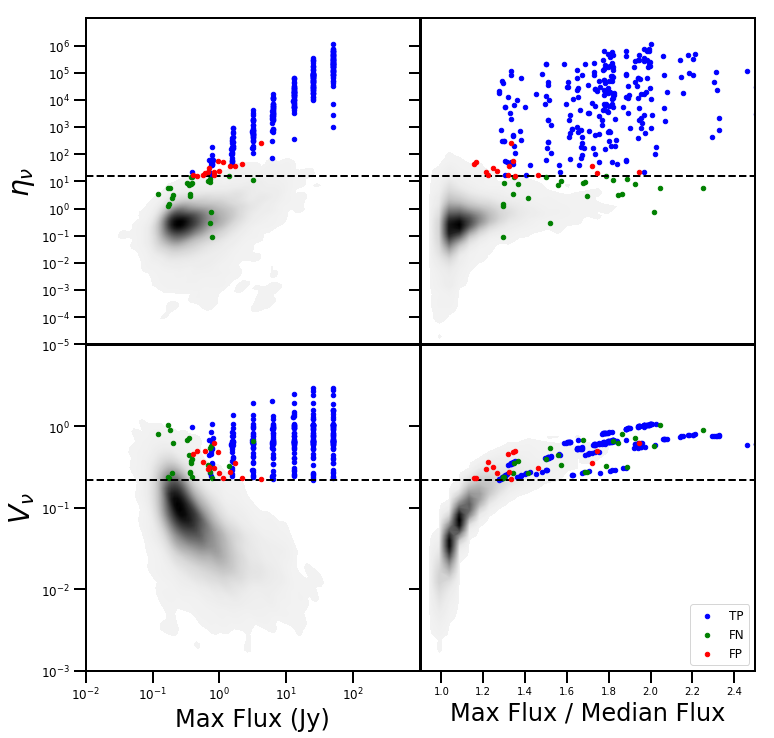

In [43]:
fig = plt.figure(1,figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fontP = FontProperties()
fontP.set_size('large')
fig.subplots_adjust(hspace = .001, wspace = 0.001)


for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_ax3=np.log10(plotdataTMP['flux'])
    xdata_ax4=plotdataTMP['fluxrat']
    ydata_ax1=np.log10(plotdataTMP['eta'])
    ydata_ax3=np.log10(plotdataTMP['V'])
    if frequencies[i] != 'TN':
        ax1.scatter(xdata_ax3, ydata_ax1,color=col[i], s=20., zorder=i)
        ax2.scatter(xdata_ax4, ydata_ax1,color=col[i], s=20., zorder=i)
        ax3.scatter(xdata_ax3, ydata_ax3,color=col[i], s=20., zorder=i)
        ax4.scatter(xdata_ax4, ydata_ax3,color=col[i], s=20., zorder=i)


ax4.legend(freq_labels, loc=4, prop=fontP)


for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_ax3=np.log10(plotdataTMP['flux'])
    xdata_ax4=plotdataTMP['fluxrat']
    ydata_ax1=np.log10(plotdataTMP['eta'])
    ydata_ax3=np.log10(plotdataTMP['V'])
    if frequencies[i] == 'TN':
        sns.kdeplot(np.log10(plotdataTMP.flux), np.log10(plotdataTMP.eta), 
                    n_levels=1000, zorder=i, shade_lowest=False, shade=True, 
                    color='k', ax=ax1, alpha=1)
        sns.kdeplot(plotdataTMP.fluxrat, np.log10(plotdataTMP.eta), 
                    n_levels=1000, zorder=i, shade_lowest=False, shade=True, 
                    color='k', ax=ax2, alpha=1)
        sns.kdeplot(np.log10(plotdataTMP.flux), np.log10(plotdataTMP.V), 
                    n_levels=1000, zorder=i, shade_lowest=False, shade=True, 
                    color='k', ax=ax3, alpha=1)
        sns.kdeplot(plotdataTMP.fluxrat, np.log10(plotdataTMP.V), 
                    n_levels=1000, zorder=i, shade_lowest=False, shade=True, 
                    color='k', ax=ax4, alpha=1)


Xax3=np.log10(plotdata['flux'])
Xax4=plotdata['fluxrat']
Yax1=np.log10(plotdata['eta'])
Yax3=np.log10(plotdata['V'])
    
if sigcutx != 0 or sigcuty != 0:
    ax1.axhline(y=sigcutx, linewidth=2, color='k', linestyle='--')
    ax2.axhline(y=sigcutx, linewidth=2, color='k', linestyle='--')
    ax3.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    ax4.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')

xmin_ax3=int(min(Xax3)-1.1)
xmax_ax3=int(max(Xax3)+1.1)
xmin_ax4=0.9
xmax_ax4=int(max(xdata_ax4))+1.5
ymin_ax1=-5#int(min(Yax1)-1.1)
ymax_ax1=int(max(Yax1)+1.1)
ymin_ax3=-3#int(min(Yax3)-1.1)
ymax_ax3=int(max(Yax3)+1.1)

xvals_ax3=range(xmin_ax3,xmax_ax3)
xtxts_ax3=[r'$10^{'+str(a)+'}$' for a in xvals_ax3]
yvals_ax1=range(ymin_ax1,ymax_ax1)
ytxts_ax1=[r'$10^{'+str(a)+'}$' for a in yvals_ax1]
yvals_ax3=range(ymin_ax3,ymax_ax3)
ytxts_ax3=[r'$10^{'+str(a)+'}$' for a in yvals_ax3]

ax1.set_ylim(ymin_ax1,ymax_ax1)
ax3.set_ylim(ymin_ax3,ymax_ax3)
ax3.set_xlim(xmin_ax3,xmax_ax3)
ax4.set_xlim(xmin_ax4,xmax_ax4)


ax3.set_xticks(xvals_ax3)
ax3.set_xticklabels(xtxts_ax3, fontsize=12)
ax1.set_yticks(yvals_ax1)
ax2.set_yticks(yvals_ax1)
ax1.set_yticklabels(ytxts_ax1, fontsize=12)
ax3.set_yticks(yvals_ax3)
ax4.set_yticks(yvals_ax3)
ax3.set_yticklabels(ytxts_ax3, fontsize=12)

ax1.set_xlim( ax3.get_xlim() )
ax4.set_ylim( ax3.get_ylim() )
ax2.set_xlim( ax4.get_xlim() )
ax2.set_ylim( ax1.get_ylim() )

ax1.xaxis.set_major_formatter(nullfmt)
ax4.yaxis.set_major_formatter(nullfmt)
ax2.xaxis.set_major_formatter(nullfmt)
ax2.yaxis.set_major_formatter(nullfmt)

ax1.set_ylabel(r'$\eta_\nu$', fontsize=28)
ax2.set_ylabel('')
ax3.set_ylabel(r'$V_\nu$', fontsize=28)
ax3.set_xlabel('Max Flux (Jy)', fontsize=24)
ax4.set_xlabel('Max Flux / Median Flux', fontsize=24)
ax4.set_ylabel('')




In [47]:
plotdata.loc[(plotdata['classified']=='FP')]

,#Runcat,Dec,RA,V,detectionThreshold,detectionThreshold,dpts,eta,flux,fluxrat,freq,label,maxRmsSigma,minRmsSigma,ttype,variable,classified
1236,10101,54.773412,38.654170,0.233531,0.0,NaN,12,51.055195,1.125984,1.164609,185,stable,0.0,0.0,2,0,FP
2003,12582,51.915637,146.916801,0.270087,0.0,NaN,24,24.516529,0.996101,1.263989,185,stable,0.0,0.0,2,0,FP
2377,12677,51.536469,150.751067,0.309932,0.0,NaN,16,17.106837,0.815625,1.463289,185,stable,0.0,0.0,2,0,FP
2380,12670,49.754788,148.187863,0.486695,0.0,NaN,8,58.269373,0.963594,1.344145,185,stable,0.0,0.0,2,0,FP
3648,10503,54.579034,53.249017,0.224956,0.0,NaN,16,252.228360,4.234522,1.331150,185,stable,0.0,0.0,2,0,FP
4270,12590,53.218277,148.216414,0.231347,0.0,NaN,32,45.147196,2.166164,1.155166,185,stable,0.0,0.0,2,0,FP
4725,10115,54.674197,40.188706,0.314016,0.0,NaN,12,29.990486,0.697412,1.245295,185,stable,0.0,0.0,2,0,FP
5069,10099,54.245287,37.692081,0.365230,0.0,NaN,12,16.523494,0.569723,1.220851,185,stable,0.0,0.0,2,0,FP
5627,12682,50.200433,151.779243,0.496730,0.0,NaN,16,21.125165,0.609621,1.745002,185,stable,0.0,0.0,2,0,FP
5634,12689,53.286199,148.629707,0.629080,0.0,NaN,16,22.354197,0.818833,1.942806,185,stable,0.0,0.0,2,0,FP
